In [1]:
import warnings, os
warnings.filterwarnings("ignore")

from copy import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, AggModel, loadmap
from aggmap.AggModel import load_model, save_model
from aggmap import show


np.random.seed(666) #just for reaptable results


def score(dfr):
    y_true = dfr.y_true
    y_pred = dfr.y_pred

    '''
    the metrics are taken from orignal paper:
    Meta-Signer: Metagenomic Signature Identifier based on Rank Aggregation of Features
    https://github.com/YDaiLab/Meta-Signer/blob/bd6a1cd98d1035f848ecb6e53d9ee67a85871db2/src/utils/metasigner_io.py#L34
    '''
    auc = np.nan #roc_auc_score(y_true, y_score, average='weighted')        
    mcc = matthews_corrcoef(y_true, y_pred)
    pres = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print('roc-auc: %.3f, mcc: %.3f, pres: %.3f, recall: %.3f, f1: %.3f' % (auc, mcc, pres, recall, f1))

    return auc, mcc, pres, recall, f1

# read data

In [15]:
task = 'CRC'
data_path = '../01_data/species_level/%s/' % (task)
save_dir = '%s_results' % task
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

dfa = pd.read_csv(os.path.join(data_path, 'abundance.tsv'),sep='\t', header=None, index_col=0)
dfy = pd.read_csv(os.path.join(data_path, 'labels.txt'),sep='\t', header=None)
dfx = dfa.T
dfy = pd.get_dummies(dfy[0].map({'cancer':2,'adenoma':1, 'n':0}))
Y = dfy.values

# generate Fmaps

In [3]:
#could be optimized
featHPs = {"best_fill":1e-8, "best_scale_method":'minmax', "best_channel_number":20}
dfx = np.log(dfx + featHPs.get('best_fill'))
mp = AggMap(dfx, metric = 'correlation')
mp = mp.fit(cluster_channels = featHPs.get('best_channel_number'), verbose = 0)
mp.plot_grid(save_dir)
mp.plot_scatter(save_dir)
mp.save(os.path.join(save_dir, 'agg.mp'))

X = mp.batch_transform(dfx.values, scale = featHPs.get('best_scale_method')) # NaN values should be the lowest value

2021-08-19 09:52:38,423 - INFO - [bidd-aggmap] - Calculating distance ...
2021-08-19 09:52:38,441 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 507/507 [00:00<00:00, 766.88it/s]


2021-08-19 09:52:44,731 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-08-19 09:52:49,858 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/134 [00:00<?, ?it/s]

2021-08-19 09:52:50,497 - INFO - [bidd-aggmap] - Finished
2021-08-19 09:52:50,498 - INFO - [bidd-aggmap] - generate file: CRC_results_test/feature points_507_correlation_umap_mp
2021-08-19 09:52:50,541 - INFO - [bidd-aggmap] - save html file to CRC_results_test/feature points_507_correlation_umap_mp
2021-08-19 09:52:50,541 - INFO - [bidd-aggmap] - generate file: CRC_results_test/feature points_507_correlation_umap_scatter
2021-08-19 09:52:50,577 - INFO - [bidd-aggmap] - save html file to CRC_results_test/feature points_507_correlation_umap_scatter


100%|##########| 134/134 [00:03<00:00, 37.30it/s]


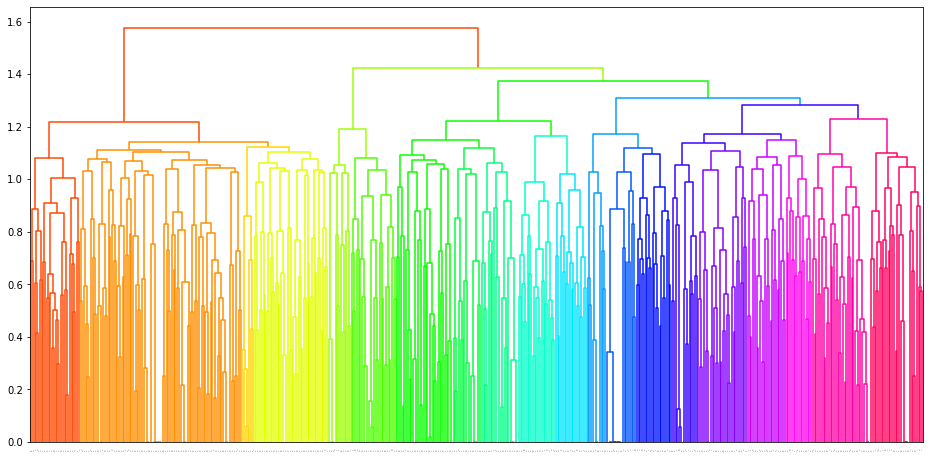

In [4]:
fig_tree = mp.plot_tree(add_leaf_labels = False, leaf_font_size = 1)
fig_tree.savefig(os.path.join(save_dir, 'tree.png'), bbox_inches='tight', dpi=300)

In [5]:
mp.fmap_shape

(23, 23)

# 10FCV

In [6]:
gpuid = 2

outer_fold = 10
repeat_seeds = [8, 16, 32, 64, 128, 256, 1024, 2048, 4096, 8192] #10 repeats random seeds 8, 16, 32, 64, 128 , 

each_fold_results = []
run_all_res = []

for i, repeat_seed in enumerate(repeat_seeds): 
    outer = StratifiedKFold(n_splits = outer_fold, shuffle = True, random_state = repeat_seed)
    outer_idx = outer.split(range(len(dfy)), dfy.idxmax(axis=1))
    run_one_res = []
    one_repeat_results = []
    for j, idx in enumerate(outer_idx):
        fold_num = "fold_%s" % str(j).zfill(2) 
        print('#'*50 + ' repeat_seed: %s; %s ' % (repeat_seed, fold_num) + '#'*50 )
        
        train_idx, test_idx = idx

        testY = Y[test_idx]
        testX = X[test_idx]
        
        trainX = X[train_idx]
        trainY = Y[train_idx]

        print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

        clf = AggModel.MultiClassEstimator(epochs = 25,  batch_size = 2, verbose = 0, gpuid=gpuid) #
        clf.fit(trainX, trainY)  #, 
        
        ## save model for explaination
        if i == 0:
            clf.save_model(os.path.join(save_dir, '%s.model' % fold_num))
            paras = clf.get_params()
            paras.update({'featHPs':featHPs})
            pd.Series(paras).to_json(os.path.join(save_dir, 'HPs.json'))

        pred_proba = clf.predict_proba(testX)
        y_true = np.argmax(testY,axis=1) 
        y_pred = np.argmax(pred_proba, axis=1)
        
        dfr = pd.DataFrame([y_true, y_pred]).T
        dfr.columns = ['y_true', 'y_pred']
        
        dfr.index = dfy.iloc[test_idx].index
        auc, mcc, pres, recall, f1  = score(dfr)
        run_one_res.append(dfr)
        
        ts = pd.Series([auc, mcc, pres, recall, f1, i, repeat_seed]).round(3)
        ts.index = ['auc', 'mcc', 'pres', 'recall', 'f1', 'i', 'repeat_seed']
        print(ts.to_dict())
        each_fold_results.append(ts.to_dict())
        one_repeat_results.append(ts.to_dict())

    print('\n\nresults for seed %s' % repeat_seed)
    print(pd.DataFrame(one_repeat_results).mean().to_dict())
    run_all_res.append(pd.concat(run_one_res))


################################################## repeat_seed: 8; fold_00 ##################################################

 input train and test X shape is (120, 23, 23, 20), (14, 23, 23, 20) 
saving model to CRC_results_test/fold_00.model
roc-auc: nan, mcc: 0.362, pres: 0.614, recall: 0.571, f1: 0.587
{'auc': nan, 'mcc': 0.362, 'pres': 0.614, 'recall': 0.571, 'f1': 0.587, 'i': 0.0, 'repeat_seed': 8.0}
################################################## repeat_seed: 8; fold_01 ##################################################

 input train and test X shape is (120, 23, 23, 20), (14, 23, 23, 20) 
saving model to CRC_results_test/fold_01.model
roc-auc: nan, mcc: 0.357, pres: 0.607, recall: 0.571, f1: 0.584
{'auc': nan, 'mcc': 0.357, 'pres': 0.607, 'recall': 0.571, 'f1': 0.584, 'i': 0.0, 'repeat_seed': 8.0}
################################################## repeat_seed: 8; fold_02 ##################################################

 input train and test X shape is (120, 23, 23, 20), (

In [8]:
pd.DataFrame(each_fold_results).groupby('repeat_seed').mean().mean()

auc           NaN
mcc       0.33956
pres      0.57675
recall    0.55687
f1        0.54892
i         4.50000
dtype: float64

In [9]:
pd.DataFrame(each_fold_results).groupby('repeat_seed').std().mean()

auc            NaN
mcc       0.182427
pres      0.132140
recall    0.118149
f1        0.120908
i         0.000000
dtype: float64

In [14]:
pd.DataFrame(each_fold_results).to_csv(os.path.join(save_dir, 'performance_results.csv'))

# feature importance

In [26]:
healthy_imps = []
adenoma_imps = []
cancer_imps = []

for i in range(10):
    clf = load_model(os.path.join(save_dir, 'fold_%s.model' % str(i).zfill(2)))
    dfe = clf.explain_model(mp, clf.X_, clf.y_, binary_task=False, apply_logrithm=False)
    healthy_imps.append(dfe.col_0_importance.to_frame(name = 'fold_%s_imp' % str(i).zfill(2)))
    adenoma_imps.append(dfe.col_1_importance.to_frame(name = 'fold_%s_imp' % str(i).zfill(2)))
    cancer_imps.append(dfe.col_2_importance.to_frame(name = 'fold_%s_imp' % str(i).zfill(2)))

  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 0 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/529 [00:00<?, ?it/s]

calculating feature importance for column 2 ...


100%|##########| 529/529 [00:13<00:00, 38.85it/s]


In [34]:
dfi = dfe[dfe.columns[:5]]
dfi['scatter_x'] = dfi.v.map(mp.df_embedding.x)
dfi['scatter_y'] = dfi.v.map(mp.df_embedding.y)

h = pd.concat(healthy_imps, axis=1).mean(axis=1).to_frame(name = 'healthy_avg_imp')
a = pd.concat(adenoma_imps, axis=1).mean(axis=1).to_frame(name = 'adenoma_avg_imp')
c = pd.concat(cancer_imps, axis=1).mean(axis=1).to_frame(name = 'cancer_avg_imp')


dfi = dfi.join(h).join(a).join(c)
dfi.to_csv(os.path.join(save_dir, 'feature_imp_results.csv'))

In [36]:
dfi

,x,y,v,Subtypes,colors,scatter_x,scatter_y,healthy_avg_imp,adenoma_avg_imp,cancer_avg_imp
0,0,0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,cluster_02,#ff8e00,-5.224070,-0.537836,-0.662816,-0.654920,-0.651090
1,1,0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,cluster_02,#ff8e00,-5.193199,-0.538442,-0.662764,-0.654960,-0.651073
2,2,0,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,cluster_02,#ff8e00,-5.188903,-0.506995,-0.662801,-0.654927,-0.651067
3,3,0,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,cluster_19,#ff00a6,-3.671085,0.387777,-0.644138,-0.637310,-0.648428
4,4,0,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,cluster_19,#ff00a6,-3.457056,0.580303,-0.601988,-0.605263,-0.633784
...,...,...,...,...,...,...,...,...,...,...
524,18,22,0,NaN,#000000,NaN,NaN,-0.663072,-0.655040,-0.651714
525,19,22,0,NaN,#000000,NaN,NaN,-0.663073,-0.655040,-0.651714
526,20,22,0,NaN,#000000,NaN,NaN,-0.663072,-0.655040,-0.651714
527,21,22,0,NaN,#000000,NaN,NaN,-0.663073,-0.655040,-0.651714


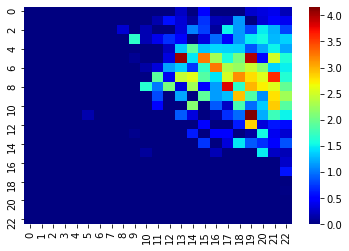

In [42]:
sns.heatmap(dfi.healthy_avg_imp.values.reshape(*mp.fmap_shape), vmin=0, cmap = 'jet')

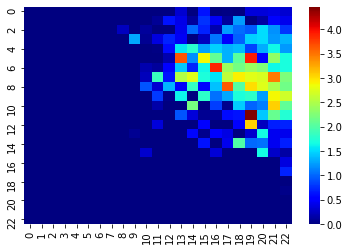

In [40]:
sns.heatmap(dfi.adenoma_avg_imp.values.reshape(*mp.fmap_shape), vmin=0, cmap = 'jet')

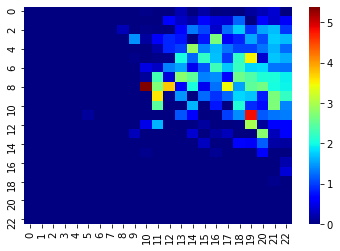

In [41]:
sns.heatmap(dfi.cancer_avg_imp.values.reshape(*mp.fmap_shape), vmin=0,  cmap = 'jet')